In [ ]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing import image
from google.colab import files


drive.mount('/content/drive')


base_dir = '/content/drive/MyDrive/PAS MP1'
training_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')
testing_dir = os.path.join(base_dir, 'testing')
class_dirs = ['cat', 'dog', 'penguin', 'turtle']


print("Jumlah Data Train Tiap Kelas")
for class_name in class_dirs:
    class_dir = os.path.join(training_dir, class_name)
    num_images = len(os.listdir(class_dir))
    print(f'Jumlah gambar {class_name}: {num_images}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Jumlah Data Train Tiap Kelas
Jumlah gambar cat: 279
Jumlah gambar dog: 278
Jumlah gambar penguin: 248
Jumlah gambar turtle: 252


In [ ]:
training_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)


training_generator = training_datagen.flow_from_directory(
    training_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)


Found 1057 images belonging to 4 classes.
Found 1057 images belonging to 4 classes.


In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(training_generator.classes),
    y=training_generator.classes
)
class_weights = dict(enumerate(class_weights))


class StopOnHighAccuracy(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > 0.99:
            print("\nAkurasi validasi > 99%. Training dihentikan.")
            self.model.stop_training = True


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,717,316 (14.18 MB)

 Trainable params: 3,717,316 (14.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    training_generator,
    steps_per_epoch=training_generator.samples // training_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[StopOnHighAccuracy()],
    class_weight=class_weights,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 1388s 43s/step - accuracy: 0.2744 - loss: 1.3766 - val_accuracy: 0.3987 - val_loss: 1.3146
Epoch 2/30
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1:28 3s/step - accuracy: 0.2188 - loss: 1.3788

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 599ms/step - accuracy: 0.2188 - loss: 1.3788 - val_accuracy: 0.4025 - val_loss: 1.3107
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.3657 - loss: 1.2900 - val_accuracy: 0.4337 - val_loss: 1.1662
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3750 - loss: 1.2098 - val_accuracy: 0.4460 - val_loss: 1.1604
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.4052 - loss: 1.1762 - val_accuracy: 0.4792 - val_loss: 1.1215
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 658ms/step - accuracy: 0.3125 - loss: 1.2084 - val_accuracy: 0.4877 - val_loss: 1.1160
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.4080 - loss: 1.1827 - val_accuracy: 0.4953 - val_loss: 1.0905
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 630ms/step - accuracy: 0.5000 - loss: 1.1249 - val_accuracy: 0.5057 - val_loss: 1.0877
Epoch 9/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.4852 - loss: 1.1361 - val_accuracy: 0.4773 - val_loss:

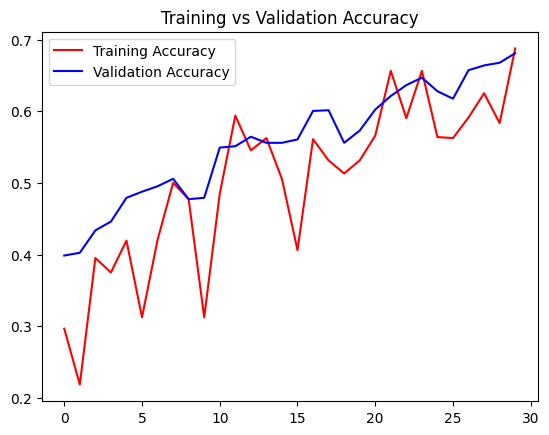

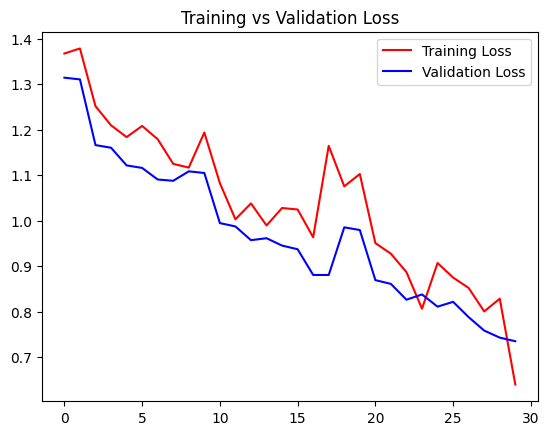

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


Saving images.jpeg to images (6).jpeg


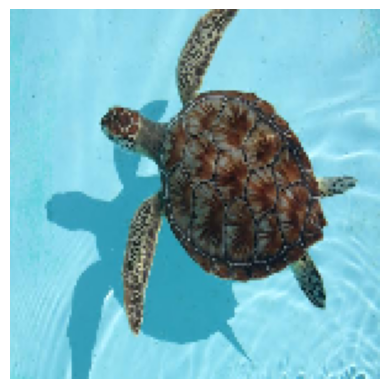

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
images (6).jpeg → Kelas: turtle (confidence: 0.71)


In [ ]:
uploaded = files.upload()

label_map = training_generator.class_indices
labels = dict((v, k) for k, v in label_map.items())

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0

    pred = model.predict(x)
    pred_class = np.argmax(pred[0])
    print(f"{fn} → Kelas: {labels[pred_class]} (confidence: {pred[0][pred_class]:.2f})")
